# 1. Load the dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Load the dataset
df = pd.read_csv('daily-minimum-temperatures-in-me.csv', parse_dates=['Date'])

# Rename column for easier referencing
df.columns.values[1] = 'Temp'

# Quick check of the dataset
print(df.head())
print(df.info())


        Date  Temp
0 1981-01-01  20.7
1 1981-01-02  17.9
2 1981-01-03  18.8
3 1981-01-04  14.6
4 1981-01-05  15.8
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3650 non-null   datetime64[ns]
 1   Temp    3650 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 57.2+ KB
None


# 2. Convert the daily temperature data to weekly averages and print the first 5 instances

In [3]:
# Ensure the DataFrame is indexed by Date for resampling
df.set_index('Date', inplace=True)

df['Temp'] = pd.to_numeric(df['Temp'], errors='coerce')

# Step 2: Resample daily temperature to weekly average
weekly_df = df.resample('W').mean()  # 'W' stands for weekly (Sunday-based by default)
# Print first 5 weekly averages
print(weekly_df.head())

                 Temp
Date                 
1981-01-04  18.000000
1981-01-11  17.542857
1981-01-18  20.371429
1981-01-25  15.771429
1981-02-01  16.657143


# 3. Plot the weekly average temperature series

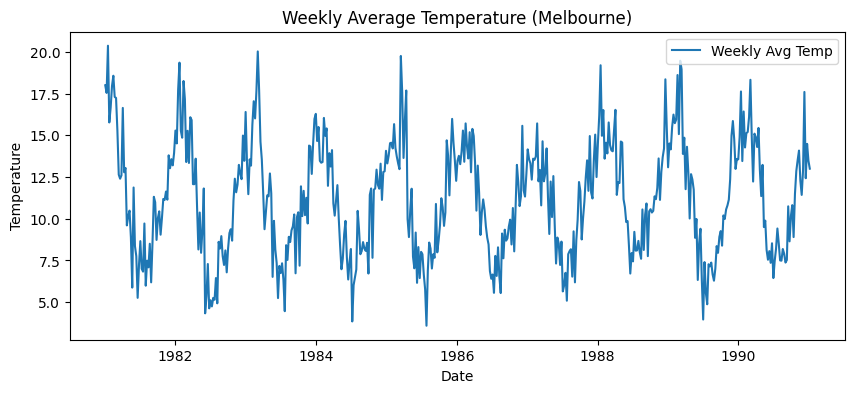

In [4]:
# Step 3: Plot the weekly average temperature
plt.figure(figsize=(10,4))
plt.plot(weekly_df.index, weekly_df['Temp'], label='Weekly Avg Temp')
plt.title('Weekly Average Temperature (Melbourne)')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()


# 4. Plot original, trend, seasonal, and residue of the series

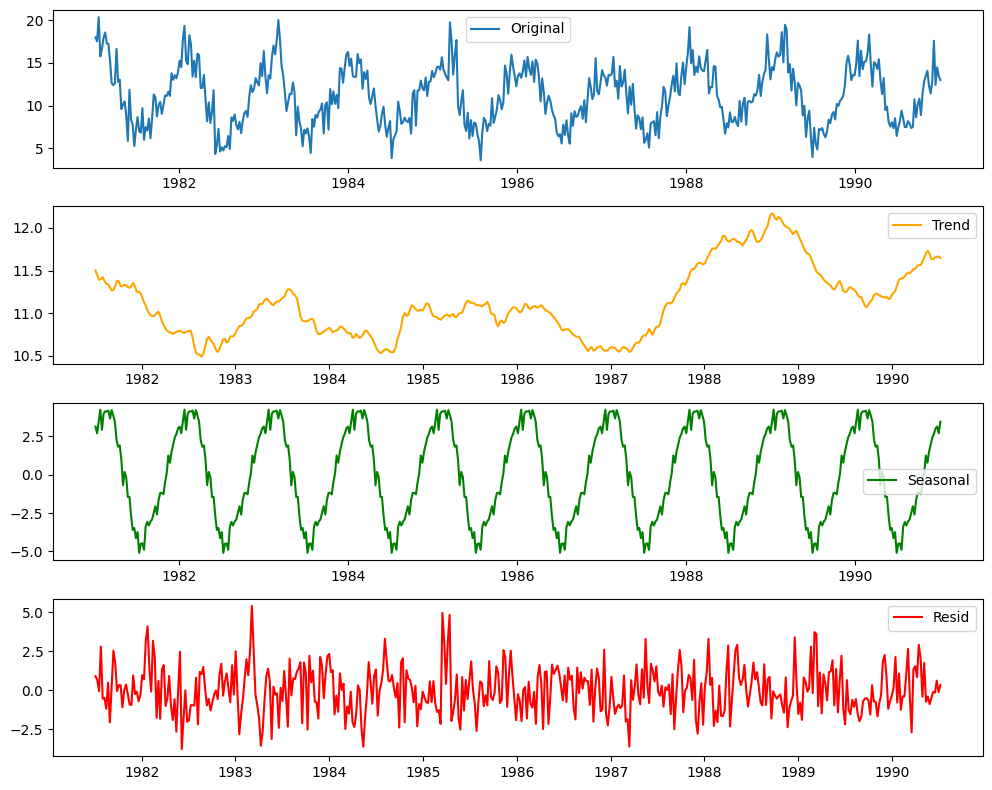

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Step 4: Decompose the weekly series
decomposition = seasonal_decompose(weekly_df['Temp'], model='additive', period=52)
# period=52 because roughly 52 weeks in a year

trend = decomposition.trend
seasonal = decomposition.seasonal
resid = decomposition.resid

# Plot
plt.figure(figsize=(10, 8))
plt.subplot(4,1,1)
plt.plot(weekly_df['Temp'], label='Original')
plt.legend(loc='best')

plt.subplot(4,1,2)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='best')

plt.subplot(4,1,3)
plt.plot(seasonal, label='Seasonal', color='green')
plt.legend(loc='best')

plt.subplot(4,1,4)
plt.plot(resid, label='Resid', color='red')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


# 5. Split data for train and test time series sequences

In [6]:
# Get the full raw series
series = weekly_df['Temp'].values  # Not yet normalized
print(f"Total sample size: {len(series)}")
train_size = int(len(series) * 0.8)

train_series = series[:train_size]
test_series = series[train_size:]


print("Training samples size:", len(train_series))
print(train_series[:5])
print("Testing samples size:", len(test_series))
print(test_series[:5])

Total sample size: 523
Training samples size: 418
[18.         17.54285714 20.37142857 15.77142857 16.65714286]
Testing samples size: 105
[14.51428571 14.15714286 15.5        16.24285714 15.72857143]


# 6. Normalize the data

In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

train_series2d = train_series.reshape(-1, 1)
test_series2d = test_series.reshape(-1, 1)

# Fit scaler ONLY on train set
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_series2d)

# Transform both sets using the same scaler
train_scaled = scaler.transform(train_series2d)
test_scaled = scaler.transform(test_series2d)
print(f"Normalised Training Samples: {train_scaled[:5]}")
print(f"Normalised Testing Samples: {test_scaled[:5]}")

Normalised Training Samples: [[0.8587234 ]
 [0.83148936]
 [1.        ]
 [0.72595745]
 [0.7787234 ]]
Normalised Testing Samples: [[0.65106383]
 [0.62978723]
 [0.70978723]
 [0.75404255]
 [0.72340426]]


# 7. Generate Sequences

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# Parameters
seq_size = 5
batch_size = 1

train_gen = TimeseriesGenerator(
    train_scaled.reshape(-1),
    train_scaled.reshape(-1),
    length=seq_size,
    batch_size=batch_size,
)

test_gen = TimeseriesGenerator(
    test_scaled.reshape(-1),
    test_scaled.reshape(-1),
    length=seq_size,
    batch_size=batch_size,
)

print("Training Sequences:")
for i in range(3):  # Print 3 batches
    x, y = train_gen[i]  # Get data and target for the batch
    print(f"Batch {i + 1}:")
    print("Data:", x)
    print("Target:", y)
    print("-" * 20)  # Separator

print("\nTesting Sequences:")
for i in range(3):  # Print 3 batches
    x, y = test_gen[i]  # Get data and target for the batch
    print(f"Batch {i + 1}:")
    print("Data:", x)
    print("Target:", y)
    print("-" * 20)  # Separator

Training Sequences:
Batch 1:
Data: [[0.8587234  0.83148936 1.         0.72595745 0.7787234 ]]
Target: [0.85617021]
--------------------
Batch 2:
Data: [[0.83148936 1.         0.72595745 0.7787234  0.85617021]]
Target: [0.89276596]
--------------------
Batch 3:
Data: [[1.         0.72595745 0.7787234  0.85617021 0.89276596]]
Target: [0.81702128]
--------------------

Testing Sequences:
Batch 1:
Data: [[0.65106383 0.62978723 0.70978723 0.75404255 0.72340426]]
Target: [0.73617021]
--------------------
Batch 2:
Data: [[0.62978723 0.70978723 0.75404255 0.72340426 0.73617021]]
Target: [0.89531915]
--------------------
Batch 3:
Data: [[0.70978723 0.75404255 0.72340426 0.73617021 0.89531915]]
Target: [0.68425532]
--------------------


# 7b Build a Sequential model with at least 2 Dense layers + output layer

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Step 7: Build a simple feedforward model
model_ff = Sequential()
model_ff.add(Dense(16, activation='relu', input_shape=(seq_size,)))  # input_shape = number of timesteps
model_ff.add(Dense(8, activation='relu'))
model_ff.add(Dense(1))  # output layer for predicting single value (next temperature)

model_ff.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 241 (964.00 B)

 Trainable params: 241 (964.00 B)

 Non-trainable params: 0 (0.00 B)

# 8. Compile and fit the model (at least 20 epochs)

In [10]:
# Step 8: Compile and fit
model_ff.compile(optimizer='adam', loss='mse')
history_ff = model_ff.fit(
    train_gen,
    epochs=20,              # at least 20 epochs
    validation_data=test_gen,
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4017 - val_loss: 0.0254
Epoch 2/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0210 - val_loss: 0.0140
Epoch 3/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0136 - val_loss: 0.0134
Epoch 4/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0131 - val_loss: 0.0124
Epoch 5/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0131 - val_loss: 0.0119
Epoch 6/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0139 - val_loss: 0.0117
Epoch 7/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0129 - val_loss: 0.0114
Epoch 8/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0121 - val_loss: 0.0113
Epoch 9/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0127 - val_loss: 0.0114
Epoch 10/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0127 - val_loss: 0.0118
Epoch 11/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0125 - val_loss: 0.0114
Epoch 12/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

# 9. Predict for the test data

In [11]:
# Step 9: Predict
predictions_ff = model_ff.predict(test_gen)

print("Predictions shape:", predictions_ff.shape)


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Predictions shape: (100, 1)


# 10. Plot the original weekly data and the prediction for the test data (denormalize predictions)

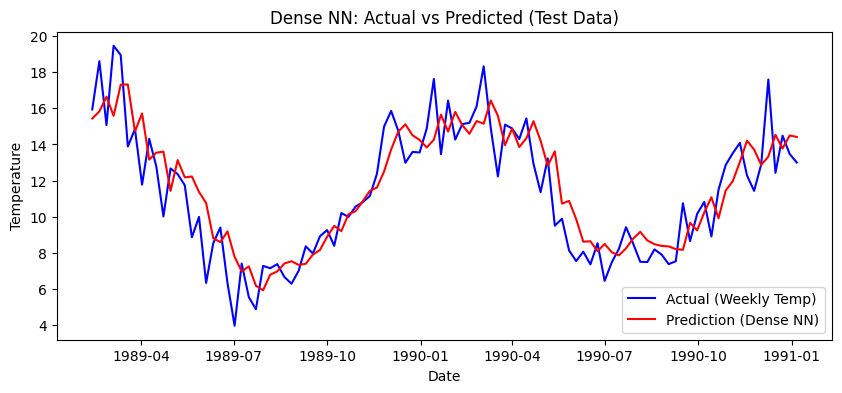

In [12]:
# Step 10: Denormalize predictions
# test_gen produces predictions for times from index train_size+seq_size onward

# Build an aligned index for the predictions

# 1) get the range of time indexes used by test_gen
test_index = weekly_df.index[train_size + seq_size:]  # because first seq_size points have no prediction

# 2) invert scaling
predictions_ff_reshaped = predictions_ff.reshape(-1, 1)
predictions_ff_denorm = scaler.inverse_transform(predictions_ff_reshaped)
#print("Predictions:", predictions_ff_denorm)

# actual test data (denormalized)
test_data = test_gen.data
actual_test = test_data[seq_size:]  # shift by seq_size
actual_test = actual_test.reshape(-1, 1)
actual_test_denorm = scaler.inverse_transform(actual_test)
#print("Actual Test:", actual_test_denorm)

plt.figure(figsize=(10,4))
plt.plot(test_index, actual_test_denorm, label='Actual (Weekly Temp)', color='blue')
plt.plot(test_index, predictions_ff_denorm, label='Prediction (Dense NN)', color='red')
plt.title('Dense NN: Actual vs Predicted (Test Data)')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()


# 11. Build a Sequential model with at least two SimpleRNN layers, same Dense layers, and a dropout layer after every RNN layer

In [13]:
from tensorflow.keras.layers import SimpleRNN, Dropout

# Step 11: Build an RNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(16, activation='relu', input_shape=(seq_size, 1), return_sequences=True))
model_rnn.add(Dropout(0.2))
model_rnn.add(SimpleRNN(8, activation='relu'))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(8, activation='relu'))
model_rnn.add(Dense(1))

model_rnn.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 5, 16)               │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 16)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 8)                   │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 569 (2.22 KB)

 Trainable params: 569 (2.22 KB)

 Non-trainable params: 0 (0.00 B)

# 12. Compile and fit the RNN model and predict (at least 20 epochs)

In [14]:
# Because we are using an RNN, we need the input data shaped (batch_size, timesteps, features).
# TimeseriesGenerator by default creates data in this shape if 'data' is 1D. Let’s confirm:

model_rnn.compile(optimizer='adam', loss='mse')
history_rnn = model_rnn.fit(
    train_gen,
    epochs=20,
    validation_data=test_gen,
    verbose=1
)

# Step 12: Predict
predictions_rnn = model_rnn.predict(test_gen)
predictions_rnn_reshaped = predictions_rnn.reshape(-1, 1)
predictions_rnn_denorm = scaler.inverse_transform(predictions_rnn_reshaped)


Epoch 1/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0389 - val_loss: 0.0223
Epoch 2/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0226 - val_loss: 0.0229
Epoch 3/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0172 - val_loss: 0.0157
Epoch 4/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0170 - val_loss: 0.0134
Epoch 5/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0180 - val_loss: 0.0138
Epoch 6/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0187 - val_loss: 0.0215
Epoch 7/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0167 - val_loss: 0.0166
Epoch 8/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0178 - val_loss: 0.0139
Epoch 9/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0145 - val_loss: 0.0137
Epoch 10/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0160 - val_loss: 0.0160
Epoch 11/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0137 - val_loss: 0.0157
Epoch 12/20
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

# 13. Plot the original weekly data and predictions from both models for the test data

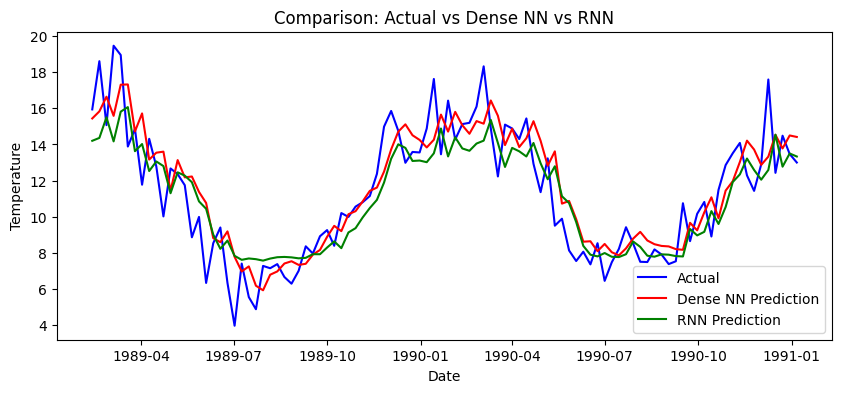

In [15]:
# We already have test_index, actual_test_denorm from before
# predictions_ff_denorm for the Dense NN
# predictions_rnn_denorm for the RNN

plt.figure(figsize=(10,4))
plt.plot(test_index, actual_test_denorm, label='Actual', color='blue')
plt.plot(test_index, predictions_ff_denorm, label='Dense NN Prediction', color='red')
plt.plot(test_index, predictions_rnn_denorm, label='RNN Prediction', color='green')
plt.title('Comparison: Actual vs Dense NN vs RNN')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()
